In [1]:
import numpy as np
import scampi_ks_solver
import matplotlib.pyplot as plt
from scipy.io import matlab
# Installl the following package from the UTIAS repository: https://github.com/utiasSTARS/liegroups
from liegroups.numpy import SO3
import time
import pandas as pd 
import csv

# IK/FK Experiments
## Extracting the Dataset

In [2]:
params = matlab.loadmat('matlab_data/real/robot_params.mat')
data   = matlab.loadmat('matlab_data/real/input_data.mat')
params.keys(), data.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'b_i_in_L', 'f_g', 'g', 'g_c', 'r_to_cog']),
 dict_keys(['__header__', '__version__', '__globals__', 'ef_poses', 'measured_cable_lengths', 'pulley1_poses', 'pulley2_poses', 'pulley3_poses', 'pulley4_poses', 'time_stamps']))

In [3]:
rot_init = data['ef_poses'][0,3:]
SO3.from_quaternion(rot_init).as_matrix()

array([[ 0.99268615,  0.11337417, -0.04147891],
       [-0.11309773,  0.99354347,  0.00895918],
       [ 0.04222684, -0.00420248,  0.99909921]])

In [4]:
robot_params = scampi_ks_solver.CableRobotParams(params['g_c'], params['f_g'])

robot_params.setCog(params['r_to_cog'])

p1 = data['pulley1_poses']
p2 = data['pulley2_poses']
p3 = data['pulley3_poses']
p4 = data['pulley4_poses']

b1 = params['b_i_in_L'][0,:]
b2 = params['b_i_in_L'][1,:]
b3 = params['b_i_in_L'][2,:]
b4 = params['b_i_in_L'][3,:]

robot_params.setEEAnchors(b1,b2,b3,b4)
gt_poses = data['ef_poses']

In [5]:
# reading optimization results
FKresults_cableforces_FK = np.array(pd.read_csv("data_from_cpp_to_python/FKresults_cableforces_FK.csv", header=None))
FKresults_test_b_in_w_FK = np.array(pd.read_csv("data_from_cpp_to_python/FKresults_test_b_in_w_FK.csv", header=None))
FKresults_test_c1_FK = np.array(pd.read_csv("data_from_cpp_to_python/FKresults_test_c1_FK.csv", header=None))
FKresults_test_c2_FK = np.array(pd.read_csv("data_from_cpp_to_python/FKresults_test_c2_FK.csv", header=None))
FKresults_test_p_platform_FK = np.array(pd.read_csv("data_from_cpp_to_python/FKresults_test_p_platform_FK.csv", header=None))
FKresults_test_rotplatform_FK = np.array(pd.read_csv("data_from_cpp_to_python/FKresults_test_rotplatform_FK.csv", header=None))

IKresults_cableforces_IK = np.array(pd.read_csv("data_from_cpp_to_python/IKresults_cableforces_IK.csv", header=None))
IKresults_test_b_in_w_IK = np.array(pd.read_csv("data_from_cpp_to_python/IKresults_test_b_in_w_IK.csv", header=None))
IKresults_test_c1_IK = np.array(pd.read_csv("data_from_cpp_to_python/IKresults_test_c1_IK.csv", header=None))
IKresults_test_c2_IK = np.array(pd.read_csv("data_from_cpp_to_python/IKresults_test_c2_IK.csv", header=None))
IKresults_test_lcat_IK = np.array(pd.read_csv("data_from_cpp_to_python/IKresults_test_lcat_IK.csv", header=None))
IKresults_test_rotplatform_IK = np.array(pd.read_csv("data_from_cpp_to_python/IKresults_test_rotplatform_IK.csv", header=None))

## Exact Reproduction of the Matlab Expriement

In [6]:
tr_errors = []
orient_errors = []
fk_poses = []
ik_lcs = []
start_time = time.time()
dts = []
for i in range(gt_poses.shape[0]):
    #Run the First Solver using the GT pose and orientation 
    pos_i = gt_poses[i,0:3]
    q_i = gt_poses[i,3:]
    R_i = SO3.from_quaternion(q_i).as_matrix()
    
    robot_params.setPulleyPoses(p1[i,:],p2[i,:],p3[i,:],p4[i,:])
    alg_start = time.time()
    
#     inverse kinematic results (R, lc_cat, cable_forces, C1, C2, b_in_w)
    R = np.array([[IKresults_test_rotplatform_IK[3*i][0], IKresults_test_rotplatform_IK[3*i][1], IKresults_test_rotplatform_IK[3*i][2]],
        [IKresults_test_rotplatform_IK[3*i+1][0], IKresults_test_rotplatform_IK[3*i+1][1], IKresults_test_rotplatform_IK[3*i+1][2]], 
        [IKresults_test_rotplatform_IK[3*i+2][0], IKresults_test_rotplatform_IK[3*i+2][1], IKresults_test_rotplatform_IK[3*i+2][2]]])

    lc_cat = np.array([IKresults_test_lcat_IK[4*i], IKresults_test_lcat_IK[4*i+1], IKresults_test_lcat_IK[4*i+2], IKresults_test_lcat_IK[4*i+3]])
        
    cable_forces = np.array([[IKresults_cableforces_IK[2*i][0], IKresults_cableforces_IK[2*i][1], IKresults_cableforces_IK[2*i][2], IKresults_cableforces_IK[2*i][3]],
                    [IKresults_cableforces_IK[2*i+1][0], IKresults_cableforces_IK[2*i+1][1], IKresults_cableforces_IK[2*i+1][2], IKresults_cableforces_IK[2*i+1][3]]])
    
    C1 = np.array(IKresults_test_c1_IK[i])   
    
    C2 = np.array(IKresults_test_c2_IK[i])

    b_in_w = np.array([[IKresults_test_b_in_w_IK[3*i][0], IKresults_test_b_in_w_IK[3*i][1], IKresults_test_b_in_w_IK[3*i][2], IKresults_test_b_in_w_IK[3*i][3]],
              [IKresults_test_b_in_w_IK[3*i+1][0], IKresults_test_b_in_w_IK[3*i+1][1], IKresults_test_b_in_w_IK[3*i+1][2], IKresults_test_b_in_w_IK[3*i+1][3]], 
              [IKresults_test_b_in_w_IK[3*i+2][0], IKresults_test_b_in_w_IK[3*i+2][1], IKresults_test_b_in_w_IK[3*i+2][2], IKresults_test_b_in_w_IK[3*i+2][3]]])

    # perturb the cable forces and gt pose of the end-effector as the inti guess
    ik_lcs.append(lc_cat)
    R_rand = SO3.exp(np.random.randn(3)*0.5*np.pi/180).as_matrix()
#     R_fk_init = R_i @ R @ R_rand
    R_fk_init = R @ R_rand
    r_rand = np.random.randn(3)*0.1
    center_fk_intit = np.array(pos_i) + r_rand
    
    lc_meas = data['measured_cable_lengths'][i,:]
#     assert False
    rand_f = (2*np.random.rand(2)-0.5)*0.1

#     forward kinematic results (fk_R, fk_r, fk_fc, fk_C1, fk_C2, fk_b_in_w)
    fk_R = np.array([[FKresults_test_rotplatform_FK[3*i][0], FKresults_test_rotplatform_FK[3*i][1], FKresults_test_rotplatform_FK[3*i][2]],
                     [FKresults_test_rotplatform_FK[3*i+1][0], FKresults_test_rotplatform_FK[3*i+1][1], FKresults_test_rotplatform_FK[3*i+1][2]], 
                     [FKresults_test_rotplatform_FK[3*i+2][0], FKresults_test_rotplatform_FK[3*i+2][1], FKresults_test_rotplatform_FK[3*i+2][2]]])

    fk_r = np.array([FKresults_test_p_platform_FK[3*i], FKresults_test_p_platform_FK[3*i+1], FKresults_test_p_platform_FK[3*i+2]])
    
    fk_fc = np.array([[FKresults_cableforces_FK[2*i][0], FKresults_cableforces_FK[2*i][1], FKresults_cableforces_FK[2*i][2], FKresults_cableforces_FK[2*i][3]],
                    [FKresults_cableforces_FK[2*i+1][0], FKresults_cableforces_FK[2*i+1][1], FKresults_cableforces_FK[2*i+1][2], FKresults_cableforces_FK[2*i+1][3]]])
    
    fk_C1 = np.array(FKresults_test_c1_FK[i])
    
    fk_C2 = np.array(FKresults_test_c2_FK[i])
    
    fk_b_in_w = np.array([[FKresults_test_b_in_w_FK[3*i][0], FKresults_test_b_in_w_FK[3*i][1], FKresults_test_b_in_w_FK[3*i][2], FKresults_test_b_in_w_FK[3*i][3]],
                 [FKresults_test_b_in_w_FK[3*i+1][0], FKresults_test_b_in_w_FK[3*i+1][1], FKresults_test_b_in_w_FK[3*i+1][2], FKresults_test_b_in_w_FK[3*i+1][3]], 
                 [FKresults_test_b_in_w_FK[3*i+2][0], FKresults_test_b_in_w_FK[3*i+2][1], FKresults_test_b_in_w_FK[3*i+2][2], FKresults_test_b_in_w_FK[3*i+2][3]]])

    fk_b_in_w = np.array([[FKresults_test_b_in_w_FK[3*i][0], FKresults_test_b_in_w_FK[3*i][1], FKresults_test_b_in_w_FK[3*i][2], FKresults_test_b_in_w_FK[3*i][3]],
                 [FKresults_test_b_in_w_FK[3*i+1][0], FKresults_test_b_in_w_FK[3*i+1][1], FKresults_test_b_in_w_FK[3*i+1][2], FKresults_test_b_in_w_FK[3*i+1][3]], 
                 [FKresults_test_b_in_w_FK[3*i+2][0], FKresults_test_b_in_w_FK[3*i+2][1], FKresults_test_b_in_w_FK[3*i+2][2], FKresults_test_b_in_w_FK[3*i+2][3]]])

    alg_end = time.time()
    dts.append(alg_end-alg_start)   
    alg_start=alg_end
    
    fk_poses.append(fk_r)
    e_r = (fk_r.squeeze() - pos_i).reshape(3,1)
    translation_error = e_r.T
    orientation_error = np.linalg.norm(SO3(fk_R.T@R).log())*180/np.pi  
    tr_errors.append(translation_error)
    orient_errors.append(orientation_error)
#     print(translation_error, orientation_error)
#     assert False
end_time = time.time()
tr_errors = np.vstack(tr_errors)
orient_errors = np.vstack(orient_errors)
ik_lcs = np.hstack(ik_lcs).T
fk_poses = np.hstack(fk_poses).T
print(f'process time for each pair of forward and inverse solvers is on average {(end_time-start_time)} ms')

process time for each pair of forward and inverse solvers is on average 0.34230852127075195 ms


In [7]:
np.savetxt('timing.csv',np.array(dts),delimiter=',')

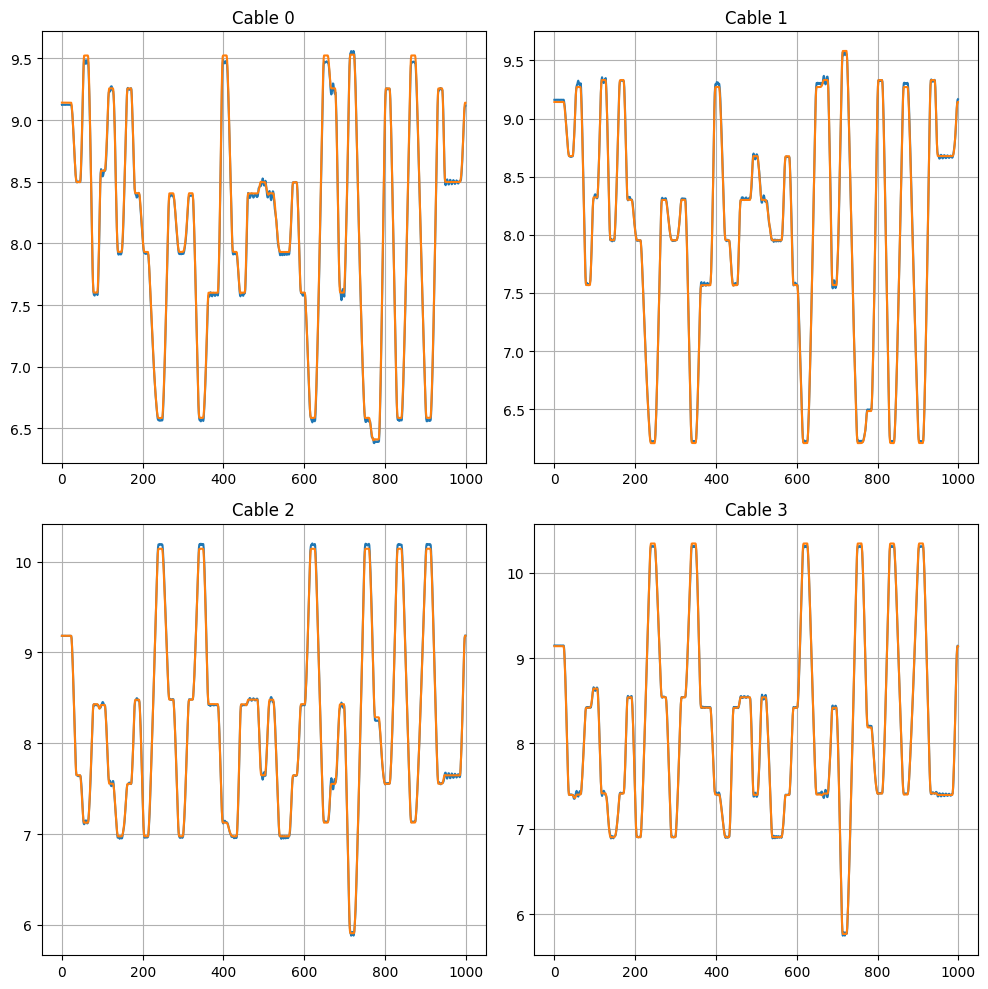

In [8]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
cnt = 0
for i in range(2):
    for j in range(2):
        ax[i][j].plot(ik_lcs[:,cnt])
        ax[i][j].plot(data['measured_cable_lengths'][:,cnt])
        ax[i][j].grid(True)
        ax[i][j].set_title(f'Cable {cnt}')
        cnt = cnt + 1
plt.tight_layout()
plt.savefig('Results/real_data/lc_solver_vs_lc_enc_matlab_exp.pdf')



## Visualization

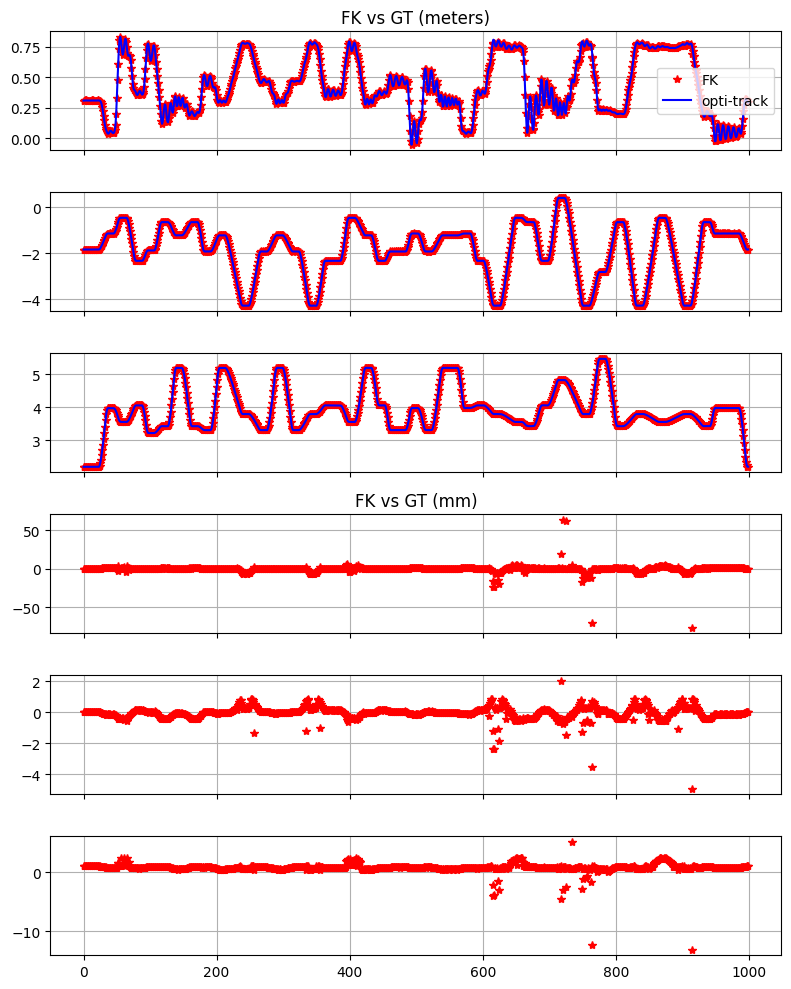

In [9]:
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(6,1, sharex = True)
ax[0].plot(fk_poses[:,0],'r*')
ax[1].plot(fk_poses[:,1],'r*')
ax[2].plot(fk_poses[:,2],'r*')
ax[0].plot(gt_poses[:,0],'b')
ax[1].plot(gt_poses[:,1],'b')
ax[2].plot(gt_poses[:,2],'b')
ax[0].set_title('FK vs GT (meters)')
ax[0].legend(['FK', 'opti-track'])

ax[3].plot(tr_errors[:,0]*1000,'r*')
ax[4].plot(tr_errors[:,1]*1000,'r*')
ax[5].plot(tr_errors[:,2]*1000,'r*')
ax[3].set_title('FK vs GT (mm)')
[ax[i].grid(True) for i in range(6)]
plt.tight_layout()

plt.savefig('Results/real_data/autodiff_errors_real_data_matlab_exp.pdf')


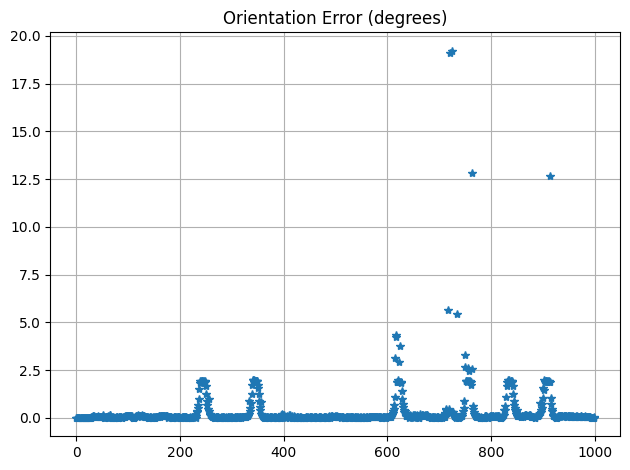

In [10]:
plt.plot(orient_errors,'*')
plt.grid(True)
plt.title('Orientation Error (degrees)')
plt.tight_layout()
plt.savefig('Results/real_data/autodiff_errors(orientation)_real_data_matlab_exp.pdf')
